## **Import Library**
Langkah pertama adalah mengimpor library Python yang dibutuhkan. Library seperti pandas dan numpy digunakan untuk mengelola data, sedangkan matplotlib dan seaborn untuk membuat visualisasi. Library dari scikit-learn digunakan untuk membangun model clustering dan mengevaluasi hasilnya.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples

from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch

## **Load & Cleaning Data**
Data transaksi dibaca dari file CSV. Karena analisis ini bertujuan mengelompokkan pelanggan, maka hanya data yang memiliki CustomerID yang digunakan. Baris tanpa CustomerID dihapus. Kemudian, dibuat kolom TotalPrice yang merupakan hasil perkalian antara jumlah barang (Quantity) dan harga per unit (UnitPrice), sebagai gambaran total belanja pelanggan di setiap transaksi.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/Machine Learning/UTS/Task 3/UTSClustering.csv", encoding='ISO-8859-1')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.dropna(subset=['CustomerID'], inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Buat Data RFM**
Langkah selanjutnya adalah merangkum data transaksi menjadi tiga variabel utama:
* Recency: Jarak hari dari transaksi terakhir pelanggan hingga tanggal referensi.
* Frequency: Jumlah transaksi unik yang dilakukan pelanggan.
* Monetary: Total nilai uang yang dibelanjakan pelanggan.

Ketiga variabel ini digunakan untuk merepresentasikan perilaku belanja setiap pelanggan.

In [ ]:
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

## **Transformasi & Standarisasi**
Nilai pada data RFM cenderung tidak merata atau memiliki rentang yang jauh berbeda. Oleh karena itu, dilakukan transformasi logaritmik untuk memperbaiki distribusi data agar tidak terlalu miring (skewed). Selanjutnya, data distandarisasi menggunakan metode StandardScaler agar semua variabel berada pada skala yang sama. Ini penting agar tidak ada satu fitur yang mendominasi hasil clustering.

In [ ]:
rfm_log = rfm.copy()
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


## **Clustering Model**
Beberapa metode clustering digunakan, yaitu:
* KMeans: Mengelompokkan data berdasarkan pusat cluster (centroid).
* Agglomerative Clustering: Menggabungkan data berdasarkan kedekatan dalam bentuk hierarki.
* DBSCAN: Mengelompokkan berdasarkan kepadatan data.
* Gaussian Mixture: Mengasumsikan data berasal dari gabungan distribusi normal.
* Spectral Clustering: Menggunakan pendekatan graf untuk memetakan hubungan antar data.

In [ ]:
# Fungsi evaluasi clustering
def evaluate_clustering(X, labels):
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    return sil, db, ch

# Inisialisasi model clustering
models = {
    "KMeans": KMeans(n_clusters=4, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=4),
    "DBSCAN": DBSCAN(eps=1.2, min_samples=5),
    "GaussianMixture": GaussianMixture(n_components=4, random_state=42),
    "SpectralClustering": SpectralClustering(n_clusters=4, random_state=42, affinity='nearest_neighbors')
}

# Tangani missing values (NaN) sebelum pemodelan
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # Bisa diganti 'median' jika lebih cocok
rfm_scaled = imputer.fit_transform(rfm_scaled)

# Evaluasi semua model
results = {}
for name, model in models.items():
    if name == "GaussianMixture":
        labels = model.fit_predict(rfm_scaled)
    else:
        labels = model.fit(rfm_scaled).labels_

    sil, db, ch = evaluate_clustering(rfm_scaled, labels)
    results[name] = {"Silhouette": sil, "Davies-Bouldin": db, "Calinski-Harabasz": ch}
    rfm[f"{name}_Cluster"] = labels


## **Evaluasi Hasil Clustering**
Setelah semua model dijalankan, hasil clustering dievaluasi menggunakan tiga metrik utama:
* Silhouette Score: Semakin tinggi nilainya, semakin baik cluster terbentuk.

* Davies-Bouldin Index: Semakin rendah nilainya, semakin baik cluster terbentuk.

* Calinski-Harabasz Score: Semakin tinggi nilainya, semakin jelas perbedaan antar cluster.

In [ ]:
results_df = pd.DataFrame(results).T
print(results_df)

                    Silhouette  Davies-Bouldin  Calinski-Harabasz
KMeans                0.374995        0.873781        4141.831522
Agglomerative         0.334355        0.925698        3576.854882
DBSCAN                0.550010        1.452221          63.828393
GaussianMixture       0.086840        2.235472        1352.859378
SpectralClustering    0.197687        1.471731        1952.389170


## **Visualisasi Silhouette & Cluster**

Silhouette plot ditampilkan untuk melihat seberapa baik setiap pelanggan masuk ke dalam clusternya. Plot ini juga membantu melihat apakah ada cluster yang terlalu sempit atau terlalu mirip satu sama lain.



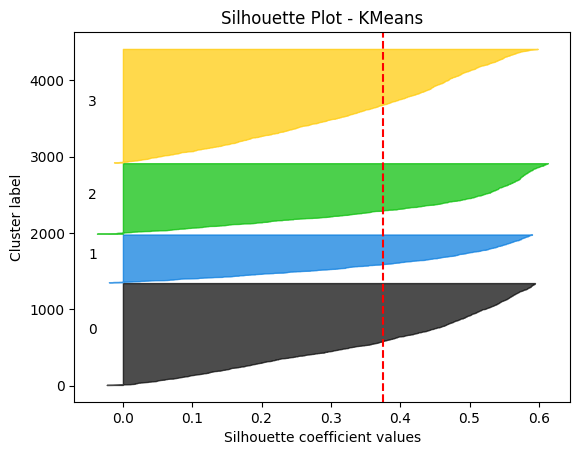

In [ ]:
# Silhouette Plot (contoh untuk KMeans)
from matplotlib import cm

def plot_silhouette(X, labels, model_name):
    silhouette_vals = silhouette_samples(X, labels)
    y_lower = 10
    for i in np.unique(labels):
        ith_cluster_silhouette = silhouette_vals[labels == i]
        ith_cluster_silhouette.sort()
        size = ith_cluster_silhouette.shape[0]
        y_upper = y_lower + size
        color = cm.nipy_spectral(float(i) / len(np.unique(labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette,
                          facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size, str(i))
        y_lower = y_upper + 10
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.title(f"Silhouette Plot - {model_name}")
    plt.axvline(x=silhouette_score(X, labels), color="red", linestyle="--")
    plt.show()

plot_silhouette(rfm_scaled, rfm["KMeans_Cluster"], "KMeans")



> Silhouette plot di atas menunjukkan hasil clustering menggunakan KMeans dengan 4 cluster (label 0–3), di mana sebagian besar pelanggan memiliki nilai Silhouette yang positif, menandakan bahwa mereka cukup cocok dengan cluster-nya masing-masing. Garis putus-putus merah menunjukkan nilai rata-rata Silhouette Score sekitar 0,39, yang tergolong cukup baik dan menunjukkan pemisahan cluster yang cukup jelas. Cluster 3 (kuning) memiliki distribusi nilai Silhouette tertinggi, menandakan kekompakan cluster yang baik, sementara cluster 0 (hitam) dan cluster 1 (biru) memiliki beberapa anggota dengan nilai mendekati nol, menunjukkan adanya pelanggan yang berada di batas antara dua cluster. Secara keseluruhan, model KMeans berhasil membentuk segmentasi pelanggan yang cukup optimal dan dapat digunakan untuk analisis lanjutan seperti strategi pemasaran yang lebih terarah.



## **Dendrogram untuk Agglomerative**
Untuk model agglomerative, digunakan dendrogram untuk memperlihatkan proses penggabungan antar pelanggan. Dari grafik ini, kita bisa memperkirakan berapa banyak cluster alami yang terbentuk berdasarkan struktur cabangnya.

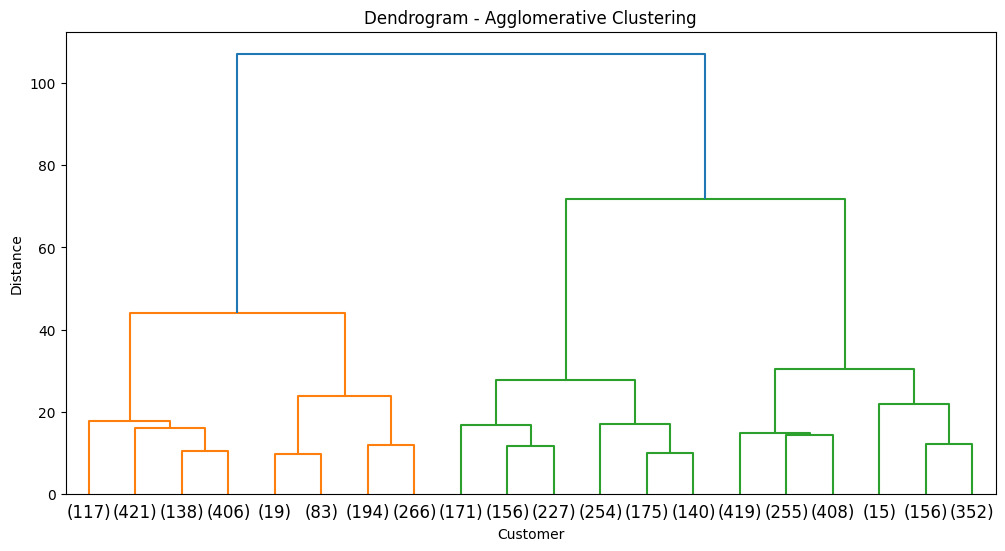

In [ ]:
linkage_matrix = linkage(rfm_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20)
plt.title("Dendrogram - Agglomerative Clustering")
plt.xlabel("Customer")
plt.ylabel("Distance")
plt.show()



> Dendrogram di atas merupakan hasil visualisasi dari metode Agglomerative Clustering, yang menggambarkan proses penggabungan pelanggan berdasarkan kemiripan perilaku belanjanya. Setiap pelanggan awalnya dianggap sebagai satu cluster terpisah, kemudian secara bertahap digabung dengan pelanggan atau kelompok lain yang paling mirip. Sumbu vertikal menunjukkan jarak atau tingkat perbedaan antar cluster saat mereka digabung, sehingga semakin tinggi garis penggabungnya, semakin besar perbedaan antar kelompok tersebut. Dari dendrogram ini, terlihat adanya dua cabang utama yang terbentuk dengan pemisahan yang cukup jelas, yang mengindikasikan bahwa pelanggan secara alami terbagi ke dalam dua kelompok besar. Dengan memotong dendrogram secara horizontal pada ketinggian sekitar 60 hingga 70, kita bisa mengidentifikasi dua cluster utama yang paling representatif.



## **Cluster Scatter Plot**
Agar data bisa divisualisasikan dalam bentuk 2 dimensi, digunakan metode PCA (Principal Component Analysis). Setelah itu, data divisualisasikan dalam bentuk scatter plot, dengan warna yang menunjukkan hasil cluster dari model. Visualisasi ini memudahkan kita melihat pola antar kelompok pelanggan.

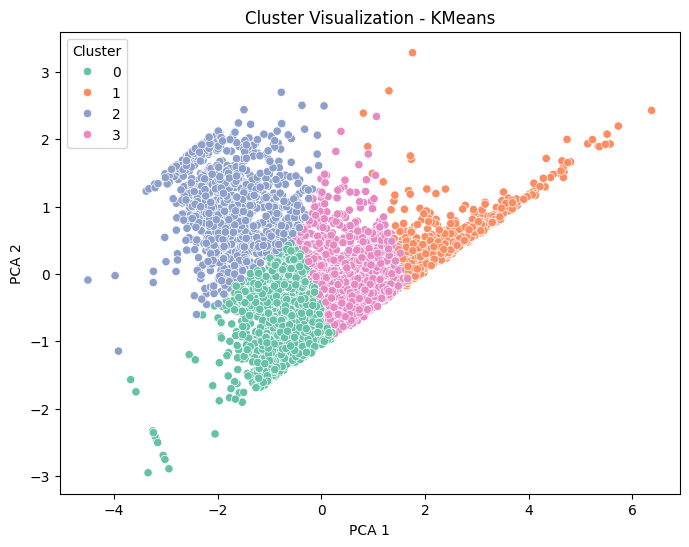

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_2d = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm_2d[:, 0], y=rfm_2d[:, 1], hue=rfm["KMeans_Cluster"], palette="Set2")
plt.title("Cluster Visualization - KMeans")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()



> Gambar di atas menunjukkan visualisasi hasil clustering pelanggan menggunakan metode KMeans yang divisualisasikan dalam dua dimensi melalui PCA (Principal Component Analysis). Setiap titik pada grafik mewakili satu pelanggan, dan warna yang berbeda menunjukkan kelompok atau cluster yang terbentuk, yaitu sebanyak empat cluster (label 0–3). Terlihat bahwa distribusi antar cluster cukup jelas dan tidak terlalu tumpang tindih, yang menunjukkan bahwa model berhasil membedakan pola perilaku belanja antar kelompok pelanggan. Misalnya, cluster dengan warna biru (cluster 2) mencakup wilayah yang luas di sisi kiri, sedangkan cluster oranye (cluster 1) tersebar di sisi kanan, menandakan adanya perbedaan karakteristik antar segmen.



## **Analisis Model Terbaik**
Berdasarkan hasil evaluasi dan visualisasi, model KMeans menunjukkan hasil yang paling baik. KMeans menghasilkan nilai Silhouette Score dan Calinski-Harabasz tertinggi serta nilai Davies-Bouldin terendah. Ini menunjukkan bahwa KMeans paling efektif dalam membentuk cluster yang jelas dan terpisah. Oleh karena itu, model ini dipilih sebagai yang terbaik untuk mengelompokkan pelanggan berdasarkan perilaku belanja mereka.

# **ANALISA**
  1. Jika algoritma K-Means menghasilkan nilai silhouette score yang rendah (misalnya 0.3) meskipun metode Elbow menunjukkan bahwa K=5 adalah jumlah cluster optimal, maka hal ini menunjukkan adanya inkonsistensi antara kuantitas pembagian cluster dan kualitas pemisahannya. Elbow method hanya mempertimbangkan penurunan total jarak dalam cluster (WCSS) tanpa memperhitungkan seberapa baik cluster terpisah satu sama lain. Sebaliknya, silhouette score mengukur seberapa dekat titik data dalam satu cluster dan seberapa jauh dari cluster lainnya. Nilai rendah menunjukkan bahwa banyak titik berada di antara dua cluster atau dalam posisi ambigu.

  Salah satu penyebab utama masalah ini adalah distribusi data yang tidak berbentuk bulat (non-spherical), sehingga centroid-based methods seperti K-Means menjadi tidak efektif karena mengasumsikan distribusi isotropik. Untuk mengatasi hal ini, strategi validasi alternatif seperti gap statistic, yang membandingkan hasil clustering dengan data acak sebagai referensi, dapat digunakan untuk penilaian yang lebih objektif terhadap jumlah cluster. Selain itu, validasi berbasis stabilitas, seperti bootstrapping, dapat menilai konsistensi hasil clustering terhadap variasi data, membantu menghindari pemilihan K yang tidak robust. Distribusi data non-spherical menjadi akar masalah karena membuat asumsi dasar K-Means—bahwa semua cluster berbentuk bulat dan memiliki variansi seragam—tidak berlaku.

  2. Dalam dataset yang memuat campuran fitur numerik seperti Quantity dan UnitPrice serta fitur kategorikal high-cardinality seperti Description, proses preprocessing harus mampu menyelaraskan skala serta merepresentasikan makna semantik dari data teks. Fitur numerik perlu dinormalisasi menggunakan teknik seperti StandardScaler atau RobustScaler agar skala antar fitur seragam dan tidak mendominasi perhitungan jarak dalam clustering. Untuk fitur teks seperti Description, penggunaan One-Hot Encoding menjadi bermasalah karena menghasilkan matriks berdimensi sangat besar dan sparse, terutama jika jumlah kata unik mencapai ribuan. Hal ini menyebabkan peningkatan kompleksitas komputasi dan menurunkan efektivitas pemisahan cluster karena banyak dimensi tidak informatif.
  Sebagai alternatif yang lebih efisien dan semantik-aware, metode seperti TF-IDF dapat menangkap pentingnya kata dalam konteks dokumen dan mempertahankan relevansi antar kata. Untuk representasi yang lebih dalam, teknik embedding seperti Word2Vec atau FastText yang kemudian direduksi menggunakan UMAP atau PCA dapat menghasilkan representasi berdimensi rendah yang lebih informatif untuk clustering. Pendekatan ini lebih robust karena mempertahankan struktur lokal dari data dan menghindari noise yang sering dihasilkan oleh encoding tradisional.

  3. Dalam penerapan algoritma DBSCAN pada dataset transaksi yang tidak seimbang, seperti kasus di mana 90% pelanggan berasal dari UK, pemilihan parameter epsilon menjadi sangat krusial. DBSCAN sangat sensitif terhadap nilai epsilon, karena parameter ini menentukan radius maksimum dari neighborhood suatu titik. Jika epsilon terlalu kecil, banyak titik akan diklasifikasikan sebagai noise; jika terlalu besar, cluster akan bergabung menjadi satu.
  Salah satu metode untuk menentukan nilai epsilon secara adaptif adalah dengan memanfaatkan k-distance graph, yaitu grafik yang memplot jarak ke tetangga ke-k untuk setiap titik. Titik “tekukan” pada grafik ini dapat dianggap sebagai nilai epsilon optimal. Pendekatan lain adalah dengan menggunakan kuartil ke-3 dari distribusi jarak sebagai dasar penentuan nilai epsilon, dengan asumsi bahwa nilai ini mampu mengakomodasi sebagian besar data tanpa menyatukan cluster yang berbeda.
  Parameter MinPts sebaiknya disesuaikan dengan jumlah dimensi atau kepadatan lokal data, karena DBSCAN mengasumsikan densitas seragam. Pada data yang sangat tidak seimbang, seperti dominasi wilayah geografis tertentu, MinPts dapat disesuaikan per region atau menggunakan algoritma varian seperti HDBSCAN yang lebih fleksibel terhadap perubahan densitas lokal.

  4. Ketika hasil analisis pasca-clustering menunjukkan adanya tumpang tindih (overlap) signifikan antara cluster yang dianggap sebagai “high-value customers” dan “bulk buyers” berdasarkan total pengeluaran, hal ini menandakan bahwa metrik jarak yang digunakan tidak mampu membedakan karakteristik utama masing-masing kelompok. Dalam kasus seperti ini, pendekatan semi-supervised seperti constrained clustering dapat diterapkan, di mana informasi parsial berupa label atau aturan bisnis digunakan untuk memandu proses clustering. Misalnya, dengan memberikan constraint must-link atau cannot-link, model akan diarahkan untuk mengelompokkan atau memisahkan data tertentu sesuai pengetahuan domain.
  Selain itu, integrasi teknik metric learning seperti Mahalanobis distance dapat membantu membentuk fungsi jarak yang lebih relevan, dengan mempertimbangkan korelasi antar fitur sehingga dua titik dengan total pengeluaran sama tetapi dengan komposisi Quantity dan UnitPrice berbeda dapat dibedakan secara lebih tajam. Namun, tantangan terbesar dari pendekatan ini adalah menurunnya interpretabilitas dari hasil clustering, terutama jika menggunakan fungsi jarak non-linear atau high-dimensional yang sulit dijelaskan kepada pemangku kepentingan bisnis yang mengandalkan keputusan berbasis pemahaman intuitif.

  5. Untuk mengidentifikasi pola pembelian periodik berdasarkan InvoiceDate, fitur temporal dapat dirancang seperti hari dalam seminggu (weekday vs. weekend), jam pembelian (pagi, siang, malam), dan apakah transaksi terjadi pada hari kerja atau libur. Informasi ini penting untuk mengenali kebiasaan pembelian pelanggan yang berbeda tergantung pada waktu. Namun, penggunaan agregasi waktu seperti rata-rata pembelian bulanan atau total belanja mingguan perlu dilakukan dengan hati-hati karena berisiko menyebabkan data leakage jika model dilatih dan diuji pada data dari periode waktu yang tumpang tindih.
  Oleh karena itu, validasi berbasis waktu seperti time-based cross-validation harus digunakan untuk memastikan bahwa model hanya menggunakan informasi masa lalu untuk memprediksi masa depan. Selain itu, penerapan fitur lag, misalnya pembelian 7 hari sebelumnya, dapat berguna tetapi juga berisiko memperkenalkan noise, terutama jika pola pembelian pelanggan tidak reguler atau jika data pembelian sebelumnya tidak tersedia secara konsisten. Oleh karena itu, fitur temporal harus dirancang dengan keseimbangan antara nilai informatif dan stabilitas terhadap noise temporal.